# Visualisierung
Graphvisualisierung ermöglicht die übersichtliche Darstellung komplexer Datenstrukturen. Sie erleichtert die Identifizierung von Mustern, Trends und zentralen Elementen in einem Netzwerk. Die Möglichkeit, komplexe Beziehungen visuell zu präsentieren, öffnet die gewonnenen Erkenntnisse aus der Graphanalyse für ein breiteres Publikum. In diesem Abschnitt werden zwei Layout-Algorithmen näher betrachtet, die physikalische Grundprinzipien

In [ ]:
import math
from random import random

import networkx as nx
from fa2_modified import ForceAtlas2

from tui_dsmt.graph import FruchtermanReingold
from tui_dsmt.graph.datasets import load_dach_cities

dach_cities = load_dach_cities()

## Inhaltsverzeichnis
- [NetworkX und einfache Darstellungen](#NetworkX-und-einfache-Darstellungen)
- [Fruchterman-Reingold Algorithmus](#Fruchterman-Reingold-Algorithmus)
- [ForceAtlas 2](#ForceAtlas-2)
- [Farbe und Größe der Knoten](#Farbe-und-Größe-der-Knoten)
- [Zusammenfassung](#Zusammenfassung)

## NetworkX und einfache Darstellungen
In den vorangegangenen Abschnitten haben Sie bereits Darstellungen von Graphen gesehen. Den einfachsten Weg, einen mit NetworkX geladenen Graphen visuell zu repräsentieren, stellt die Funktion `draw` dar. Mit den vorhandenen Parametern können Sie unter anderem die Namen der Knoten einblenden lassen, die Schriftfarbe verändern oder auch die Position der Knoten vorgeben.

In [ ]:
nx.draw(dach_cities, pos={
    'Hannover': (-1.0, 0.0),
    'Frankfurt': (-0.8, -0.6 ),
    'Hamburg': (-0.3, -1),
    'Berlin': ( 0.3, -1),
    'Zürich': ( 0.8, -0.6),
    'Wien': (1.0, 0.0),
    'Mannheim': (0.8  , 0.6),
    'Stuttgart': (0.3, 1.0 ),
    'Dresden': (-0.3,  1.0),
    'München': (-0.8,  0.6)
})

Die Positionen der Knoten händisch zu bestimmen ist bei Graphen einer gewissen Größe natürlich unrealistisch, weshalb NetworkX [eine ganze Reihe unterschiedlicher Funktionen](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) bereitstellt. Falls Sie der Funktion `draw` keine Positionen - weder manuell noch anderweitig berechnet - vorgeben, wird auf `spring_layout` zurückgegriffen.

In [ ]:
nx.draw(dach_cities)

Wenn Sie die Zelle wiederholt ausführen, werden Sie feststellen, dass sich das Ergebnis ändert. Um ein konstantes Ergebnis zu erzeugen, müssen Sie eine der Layout Funktionen verwenden und die Initialisierung des Zufallszahlengenerators, die durch den Parameter `seed` bestimmt wird, auf einen festen Wert setzen.

## Fruchterman-Reingold Algorithmus
Das *Spring Layout* (wie Feder, nicht wie Frühling!) verwendet den Fruchterman-Reingold Algorithmus, der auf physikalischen Prinzipien beruht. Es werden dazu zwei Arten von Kräften simuliert:
1. Knoten stoßen sich gegenseitig ab. Die Abstoßung ist umso stärker, je näher sie beieinander liegen.
2. Kanten ziehen verbundene Knoten wie Federn zusammen. Die Anziehung ist umso stärker, je weiter sie voneinander entfernt liegen.

Mit den korrekten Parametern ergibt sich dann ein Layout, das die Knoten gleichmäßig über die zur Verfügung stehende Fläche verteilt und adjazente Knoten in räumlicher Nähe zueinander positioniert.

### Initialisierung
Zu Beginn des Algorithmus muss für jeden Knoten eine initiale Position gefunden werden. Diese kann entweder durch einen simpleren Layout-Algorithmus gefunden oder zufällig gewählt werden.

In [ ]:
def init_pos():
    return {
        node: (random(), random())
        for node in dach_cities
    }

nx.draw(dach_cities, init_pos())

### Berechnung der abstoßenden und anziehenden Kräfte
Für jedes Paar von Knoten werden nun die abstoßenden und die anziehenden Kräfte berechnet.

#### Abstoßende Kräfte
Charles Augustin de Coulomb gilt als Begründer Elektrostatik. Das von ihm im 18. Jahrhundert entdeckte Coulombsche Gesetz besagt, dass zwei als Punkte angenommene Ladungen aufeinander eine Kraft ausüben. So ziehen sich zwei ungleiche Ladungen an, während sich zwei gleiche Ladungen abstoßen. Die Kraft wirkt dabei in Richtung der Verbindungsgeraden zwischen den beiden Ladungen, während sich der Betrag proportional zum Produkt der beiden Ladungsmengen und umgekehrt proportional zum Abstand der beiden Ladungen verhält.

<p>
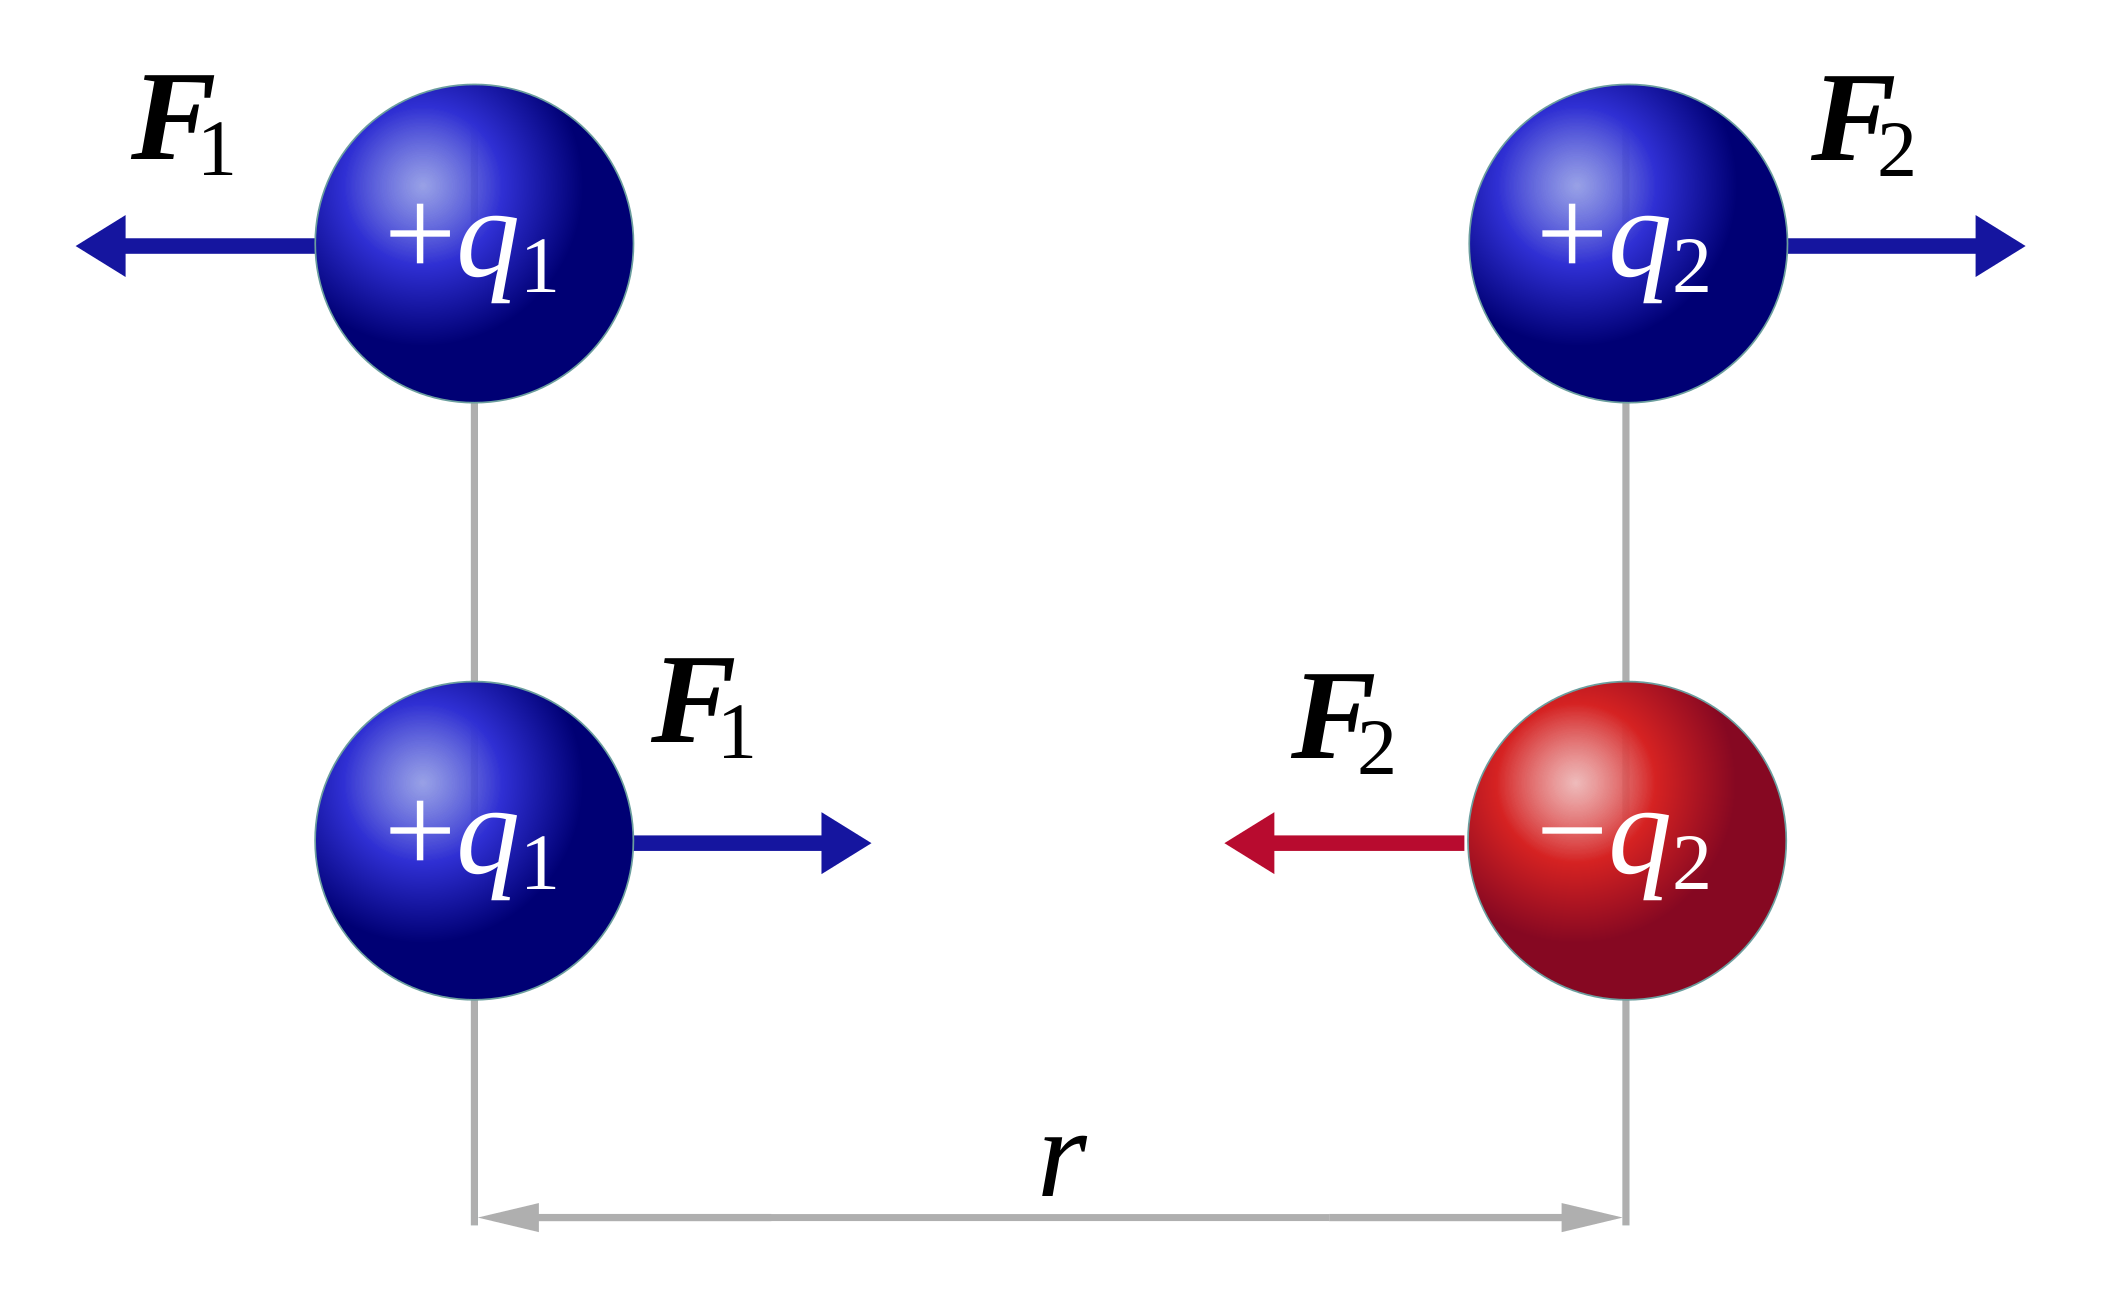 <br>
<a href="https://commons.wikimedia.org/wiki/File:CoulombsLaw.svg">Coulombsches Gesetz (Dna-Dennis | CC BY 3.0)</a>
</p>

Übertragen auf einen Graphen kann man nun davon ausgehen, dass alle Knoten gleich geladene Punkte sind. Die Stärke der Ladung als Einflussfaktor auf die Kraft wird durch einen festzulegenden Paramter $r$ beschrieben. Anschließend lässt sich die abstoßende Kraft (*repelling force*) $F_R$ auf einen Knoten $u$ an Position $p_u$ durch einen anderen Knoten $v$ an Position $p_v$ wie folgt berechnen:

$$ F_R(u, v) = -\frac{r^2}{\lVert \overrightarrow{p_u p_v} \rVert} * \overrightarrow{p_u p_v} $$

Die nachfolgende Python-Funktion drückt die Verschiebung eines Knotens durch den abstoßenden Einfluss eines anderen aus:

In [ ]:
def F_r(pos_u, pos_v, r):
    uv = (pos_v[0] - pos_u[0], pos_v[1] - pos_u[1])
    m = -(r ** 2) / math.sqrt(uv[0] ** 2 + uv[1] ** 2)

    return m * uv[0], m * uv[1]

#### Anziehende Kräfte
Das von Robert Hooke bereits im 17. Jahrhundert publizierte Hookesche Gesetz beschreibt die Kraft, die erforderlich ist, um eine Feder zu dehnen. Es besagt, dass sich die auf eine Feder ausgeübte Kraft proportional zur Dehnung verhält. Der Proportionalitätsfaktor $k$ beschreibt dabei die Stärke der Feder.

<p>
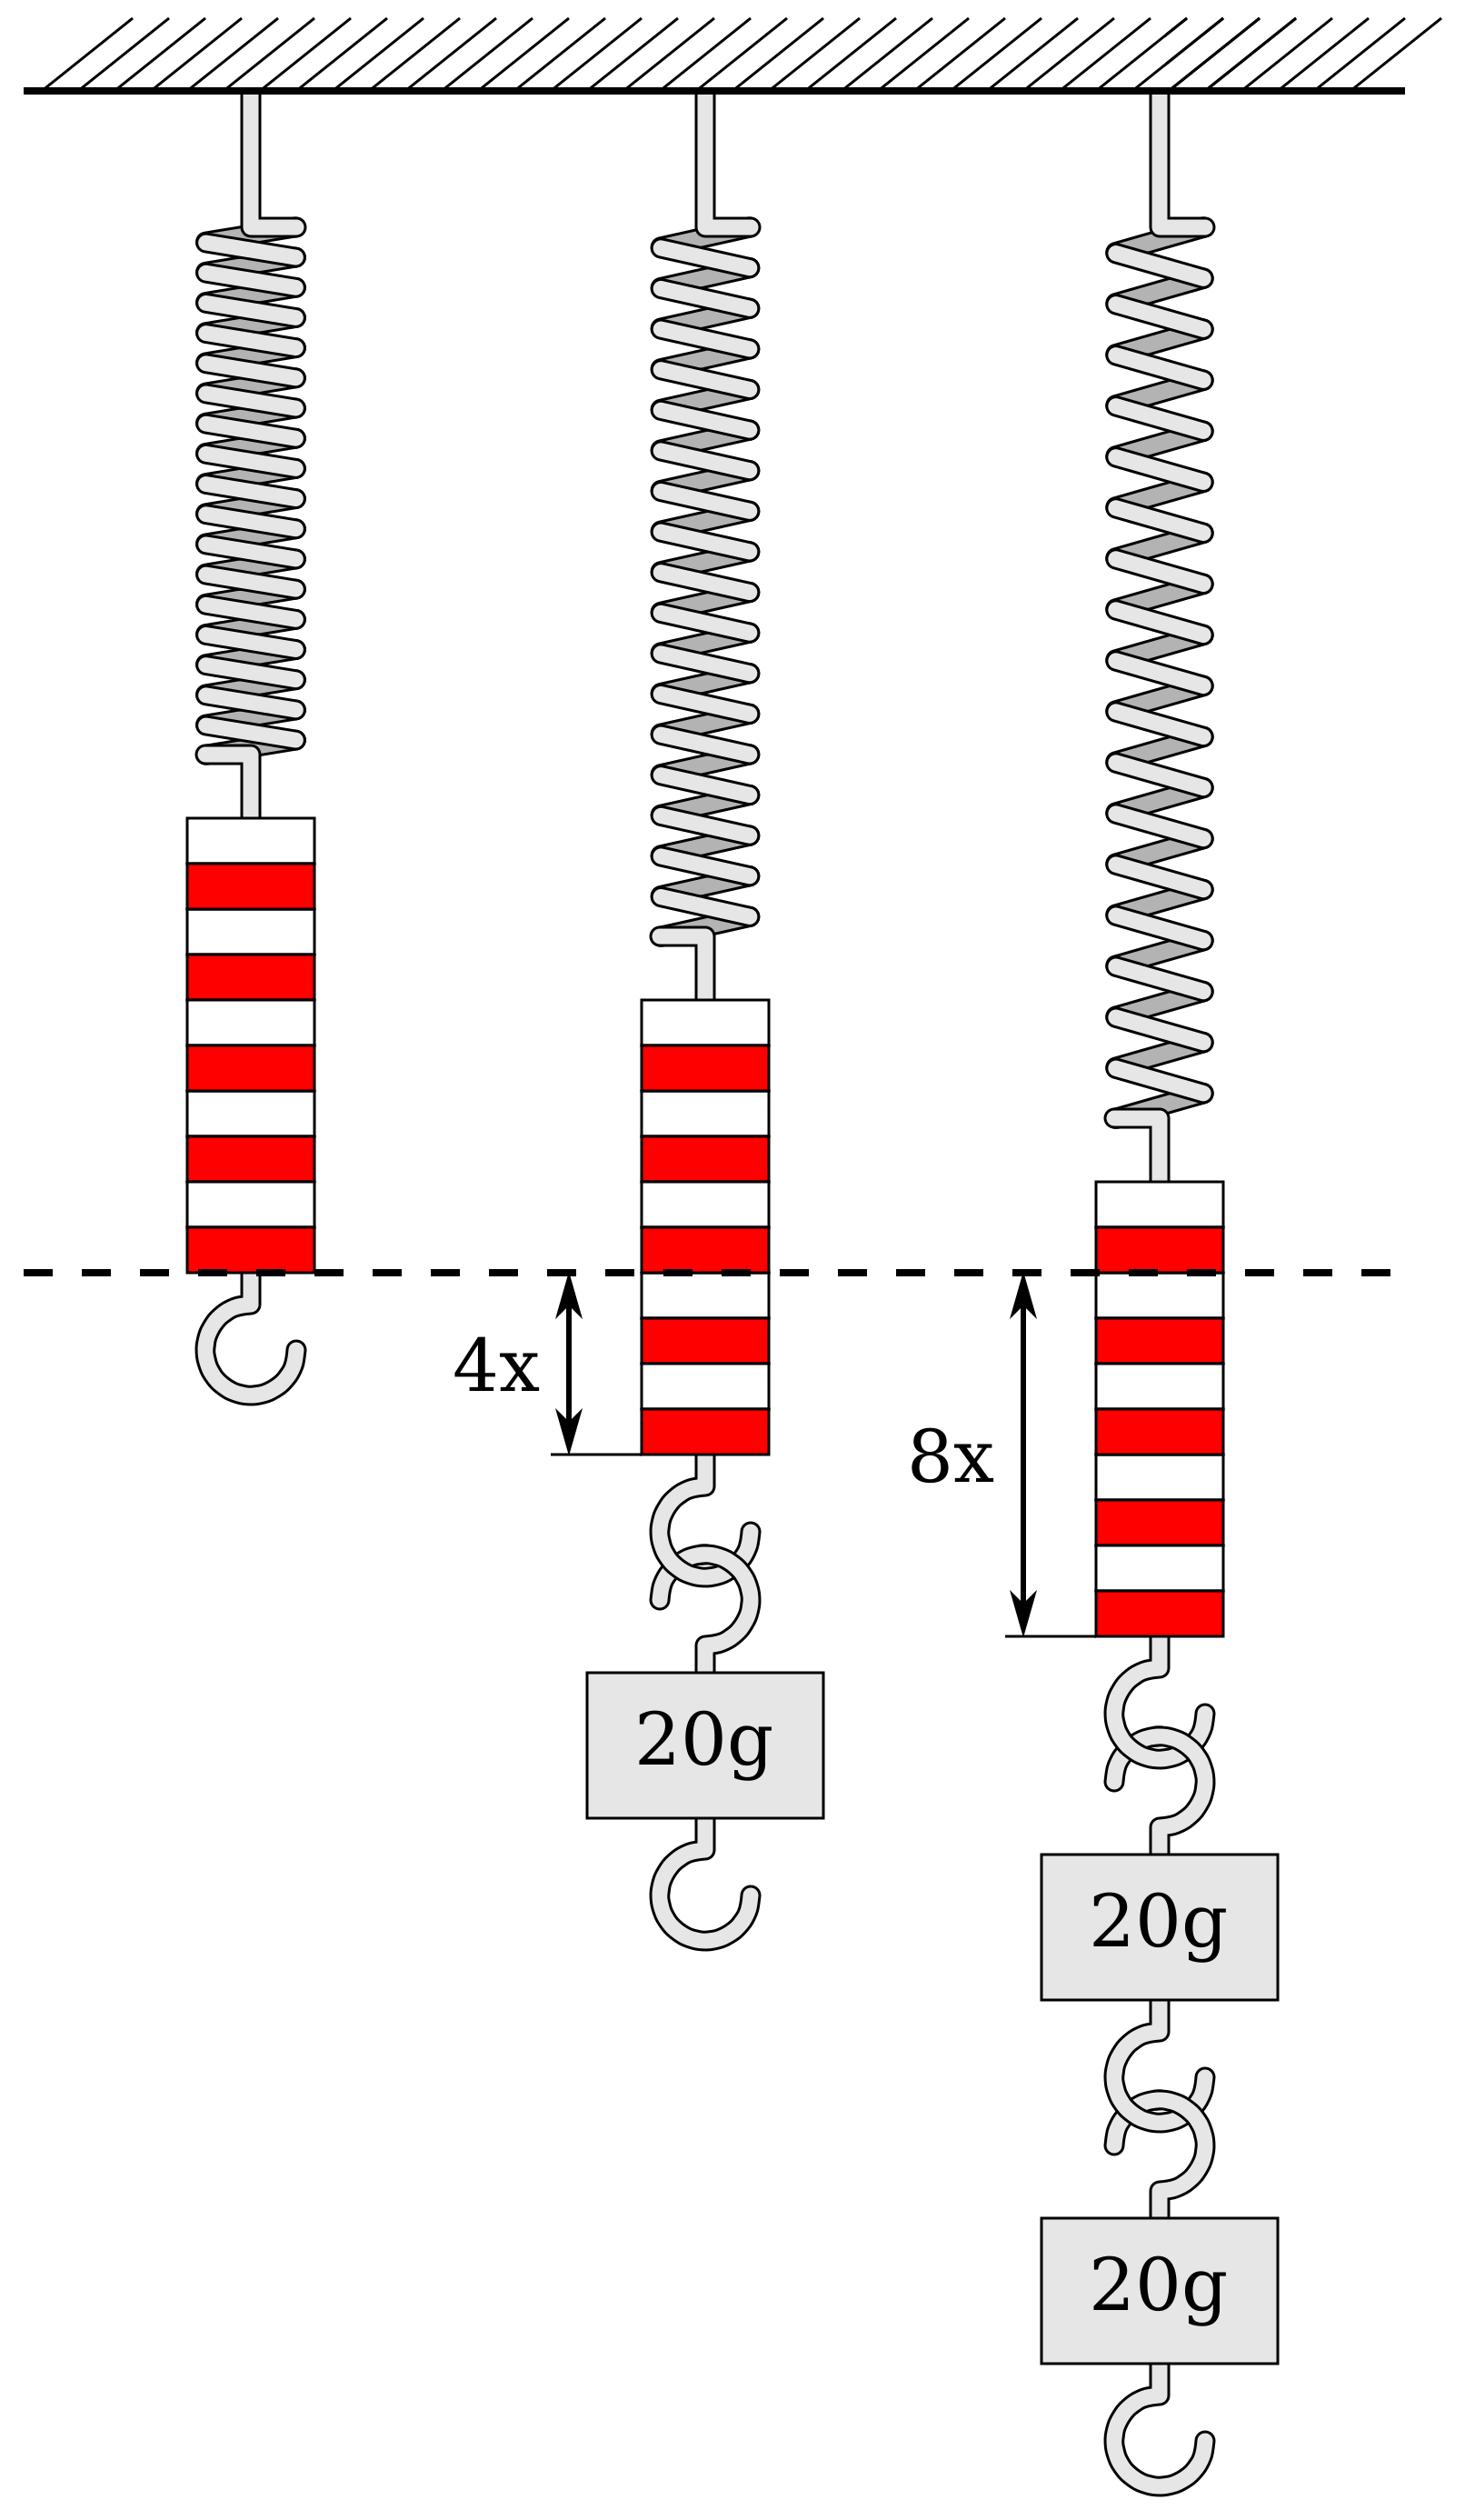 <br>
<a href="https://commons.wikimedia.org/wiki/File:Hookesches_Gesetz.svg">Hookesches Gesetz (Menner | CC0)</a>
</p>

Das Gesetz wurde ursprünglich in Zusammenhang mit durch die Gravitation beschleunigten Gewichten beschrieben. Die Kraft zwischen zwei beliebigen Punkten ist dabei ebenfalls in Richtung ihrer Verbindungsgeraden gerichtet.

Übertragen auf zwei durch eine Kante verbundene Knoten $u$ und $v$ innerhalb eines Graphen lässt sich die Federkraft (*attracting force*) unter Berücksichtigung des Parameters $k$ wie folgt ausdrücken:

$$ F_A(u, v) = \frac{{\lVert \overrightarrow{p_u p_v} \rVert}^2}{k} * \overrightarrow{p_u p_v} $$

Zur weiteren Verwendung halten wir auch dies in einer Python Funktion fest:

In [ ]:
def F_a(pos_u, pos_v, k):
    uv = (pos_v[0] - pos_u[0], pos_v[1] - pos_u[1])
    m = (uv[0] ** 2 + uv[1] ** 2) / k

    return m * uv[0], m * uv[1]

### Temperaturkontrolle
Die Temperaturkontrolle ist ein wichtiger Mechanismus, der einen Abkühlungsprozess während der Iterationen simuliert. Die Temperatur wird verwendet, um die Stärke der Bewegung der Knoten im Layout zu regulieren, und nach und nach verringert, um eine allmähliche Stabilisierung des Layouts zu ermöglichen. Das System soll während der Anfangsphasen *heiß* sein und sich schnell verändern, während es zum Ende hin immer *kälter* und stabiler wird.

Dazu wird die Temperatur $temp \in \mathbb{R}^+$ mit einem Anfangswert belegt, der im Laufe der Iterationen immer wieder mit einem Abkühlungsfaktor $c \in (0, 1)$ multipliziert wird. Eine Untergrenze für die Temperatur stellt sicher, dass keine Iterationen mit einem Faktor zu nahe an $0$ erfolgen.

In [ ]:
start_temp = 0.1
min_temp = 0.01

c = 0.95

### Finaler Algorithmus
Der finale Algorithmus setzt die besagten Schritte nun zusammen und führt eine festgelegte Anzahl an Iterationen durch. Während einer Iteration werden die Kräfte dabei zunächst gesammelt und dann gemeinsam angewendet.

In der Regel wird die Federkonstante $k$ für die Berechnung beider Kräfte verwendet und auf $\sqrt{\frac{1}{\left|V\right|}}$ gesetzt. Die Initialisierung wird im nachfolgenden Beispiel zufällig vorgenommen.

In [ ]:
iterations = 100
r = math.sqrt(1.0 / len(dach_cities))
k = r

pos = init_pos()
current_temp = start_temp

for _ in range(iterations):
    delta = {}

    # abstoßende Kräfte
    for u, pos_u in pos.items():
        delta[u] = (0, 0)

        for v, pos_v in pos.items():
            # gleiche Knoten und gleiche Positionen überspringen,
            # sonst 0 im Nenner!
            if pos_u == pos_v:
                continue

            # Bewegung bestimmen
            d = F_r(pos_u, pos_v, r)
            delta[u] = delta[u][0] + d[0], delta[u][1] + d[1]

            # symmetrischer Fall (v, u) wird später behandelt!

    # anziehende Kräfte
    for u, v in dach_cities.edges:
        pos_u = pos[u]
        pos_v = pos[v]

        # Bewegung bestimmen und Positionen anpassen
        d = F_a(pos_u, pos_v, k)

        delta[u] = delta[u][0] + d[0], delta[u][1] + d[1]
        delta[v] = delta[v][0] - d[0], delta[v][1] - d[1]

    # Anpassung der Positionen
    for u in delta:
        pos[u] = pos[u][0] + delta[u][0] * current_temp, pos[u][1] + delta[u][1] * current_temp

    # Anpassung der Temperatur
    current_temp = max(min_temp, current_temp * c)

nx.draw(dach_cities, pos)

Die gezeigte Variante ist wenig stabil und das Ergebnis hängt stark von der Wahl der Parameter ab. Für die Darstellung größerer Graphen sollten Sie deshalb auf etablierte und performantere Implementierungen zurückgreifen, die zumindest zusätzlich eine Minimaldistanz zwischen den Knoten und eine Normalisierung der Koordinaten berücksichtigen.

Auch von Einfluss ist die zufällige Initialisierung. Führen Sie die Zelle daher mehrfach aus und beobachten Sie das Ergebnis.

Für den Fruchterman-Reingold-Algorithmus steht ebenfalls eine animierte Variante bereit:

In [ ]:
FruchtermanReingold(dach_cities)

## ForceAtlas 2
ForceAtlas 2 ist ein ebenfalls auf physikalischen Prinzipien basierendes Graphenlayout, das verschiedene Erweiterungstechniken integriert und eine Vielzahl an Einstellungsmöglichkeiten bietet. Gleichzeitig gilt ForceAtlas 2 als performanter Algorithmus, der auch mit Netzwerken mit tausenden Knoten umgehen kann.

Der Algorithmus ist in Gephi integriert und lässt sich interaktiv bei der Arbeit beobachten. An dieser Stelle soll dagegen nur kurz eine Python Bibliothek gezeigt werden, die einen Teil der Funktionen implementiert.

In [ ]:
fa2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1.0,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.9,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=3.0,
    strongGravityMode=False,
    gravity=1,

    # Log
    verbose=True
)

pos = fa2.forceatlas2_networkx_layout(dach_cities, pos=None, iterations=3000)
nx.draw(dach_cities, pos)

## Farbe und Größe der Knoten
Besonders interessant werden Darstellungen dann, wenn weitere darstellerische Möglichkeiten zur Vermittlung von Informationen verwendet werden. Am beliebtesten dazu ist die Veränderung der Größe der Knoten und das Einfärben dieser.

In einem fortgeschrittenen Kapitel werden wir diese Idee erneut aufgreifen.

## Zusammenfassung
Für große Graphen ein sinnvolles Layout zu finden ist eine komplexe Aufgabe. In diesem Abschnitt haben wir zwei Algorithmen angeschnitten, die physikalische Prinzipien verwenden, um ein solches Layout zu finden. Anhand eines Beispiels wurde außerdem gezeigt, dass über die Größe und Farbe der Knoten weitere Informationen in die entstehende Visualisierung eingebracht werden können.